In [1]:
# =========================
# BLOCK 1 — PREPROCESSING
# =========================
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# ---- File paths ----
BASE = "/Users/adithyamadduri/Downloads/syn65414912"
ANML_PATH   = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_protein_level_ANML_log10.csv")
SAMPLE_PATH = os.path.join(BASE, "OhNM2025_ROSMAP_plasma_Soma7k_sample_metadata.csv")

# ---- Load ----
df_levels = pd.read_csv(ANML_PATH)        # rows: projid_visit, cols: proteins
df_meta   = pd.read_csv(SAMPLE_PATH)      # contains projid_visit, projid, msex, age_at_visit, educ, apoe_genotype, Diagnosis

# ---- Sanity: keys present? ----
assert "projid_visit" in df_levels.columns, "projid_visit missing in protein matrix."
for col in ["projid_visit","projid","msex","age_at_visit","educ","apoe_genotype","Diagnosis"]:
    assert col in df_meta.columns, f"{col} missing in sample metadata."

# ---- Align on visit ----
# inner join so we only keep visits present in BOTH
df = pd.merge(df_meta, df_levels, on="projid_visit", how="inner", validate="one_to_one")
print("Aligned shape:", df.shape)

# ---- Labels (four groups) ----
df["Diagnosis"] = df["Diagnosis"].astype(str).str.strip()
valid_classes = {"MCI","NCI","AD","AD+"}
df = df[df["Diagnosis"].isin(valid_classes)].reset_index(drop=True)
print("Class counts:\n", df["Diagnosis"].value_counts())

# ---- Grouping key for leakage control ----
df["projid"] = df["projid"].astype(str)

# ---- Stratification label: Diagnosis × sex (0/1) ----
df["msex"] = df["msex"].astype(int)
df["strata"] = df["Diagnosis"] + "_" + df["msex"].astype(str)

# ---- APOE one-hot (Unknown for NaN) ----
def format_apoe(x):
    if pd.isna(x):
        return "Unknown"
    try:
        # e.g., 33.0 -> "33"
        return str(int(float(x)))
    except Exception:
        s = str(x).strip()
        return s if s else "Unknown"

df["apoe_str"] = df["apoe_genotype"].apply(format_apoe)

# scikit-learn compatibility across versions
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

apoe_ohe = ohe.fit_transform(df[["apoe_str"]])
apoe_cols = [c.replace("apoe_str_","APOE_") for c in ohe.get_feature_names_out()]
df_apoe  = pd.DataFrame(apoe_ohe, columns=apoe_cols, index=df.index)

# ---- Numeric covariates (unscaled) ----
for col in ["age_at_visit","educ"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ---- Protein feature columns ----
protein_cols = [c for c in df_levels.columns if c != "projid_visit"]

# ---- Final feature matrix X ----
X = pd.concat([df[["age_at_visit","educ"]], df_apoe, df[protein_cols]], axis=1)
y = df["Diagnosis"].astype(str).values
groups = df["projid"].values
strata = df["strata"].values

print("X shape:", X.shape)
print("APOE levels seen:", sorted(set(df["apoe_str"])))

Aligned shape: (973, 7301)
Class counts:
 Diagnosis
NCI    507
MCI    262
AD     167
AD+     17
Name: count, dtype: int64
X shape: (953, 7298)
APOE levels seen: ['22', '23', '24', '33', '34', '44', 'Unknown']


In [2]:
import os
import pickle
import pandas as pd
from collections import Counter

# ---- Config ----
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_fixed"
classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c): return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

# ---- Track all features with non-zero importance ----
# ---- Track features with non-zero importance PER CLASS ----
from collections import defaultdict

feature_counts_per_class = defaultdict(Counter)

for seed in seeds:
    for cls in classes:
        model_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl")
        if not os.path.exists(model_path):
            print(f"Missing: {model_path}")
            continue

        with open(model_path, "rb") as f:
            automl = pickle.load(f)

        importances = automl.model.estimator.feature_importances_
        features = automl.feature_names_in_
        nonzero_features = [feat for feat, imp in zip(features, importances) if imp > 0]
        feature_counts_per_class[cls].update(nonzero_features)

# ---- Filter to features appearing in at least 3 models ----
# ---- Get shared features per class (appearing in ≥3 models) ----
shared_features_per_class = {
    cls: [feat for feat, count in counter.items() if count >= 2]
    for cls, counter in feature_counts_per_class.items()
}

# ---- Output folder ----
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
os.makedirs(out_dir, exist_ok=True)

for cls in classes:
    feats = shared_features_per_class.get(cls, [])
    print(f"[{cls}] Found {len(feats)} features with non-zero importance in ≥3 models.")

# =========================
# BLOCK 2 — RATIO TRAINING WITH RFE
# CHANGE: For each one-vs-all run, use ONLY the features that appear in ≥3 seeds for THAT CLASS.
# Assumes upstream variables exist: `X` (samples × features), `y` (labels),
# `protein_cols` (list of protein feature columns), `strata` (stratifier), `groups` (group ids).
# =========================
import numpy as np
from itertools import combinations
from flaml import AutoML
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier

# ---- Classes & seeds (kept for fidelity) ----
classes = ["MCI","NCI","AD","AD+"]
def safe_cls(c): return c.replace("+","plus").replace(" ","_").replace("/","-")
seeds = [1,2,3,4,5]

# ---- Custom group-aware stratified 70/30 split ----
def group_stratified_shuffle_split(df_index, strata_all, groups_all, test_size=0.30, random_state=0):
    rng = np.random.RandomState(random_state)
    data = pd.DataFrame({"idx": df_index, "strata": strata_all, "group": groups_all})
    grp_mode = data.groupby("group")["strata"].agg(lambda s: s.value_counts().idxmax())
    grp_mode = grp_mode.sample(frac=1.0, random_state=random_state)

    train_groups, test_groups = [], []
    for s_val, grp_ids in grp_mode.groupby(grp_mode.values):
        g_list = list(grp_ids.index)
        rng.shuffle(g_list)
        n_test = max(1, int(round(test_size * len(g_list))))
        test_groups.extend(g_list[:n_test])
        train_groups.extend(g_list[n_test:])

    train_mask = np.isin(groups_all, train_groups)
    test_mask = np.isin(groups_all, test_groups)
    return np.where(train_mask)[0], np.where(test_mask)[0]

# ---- FLAML training loop (per-class feature selection & ratios) ----
for cls in classes:
    # 1) Use only predictive features (≥3 seeds) for THIS class
    class_feats = shared_features_per_class.get(cls, [])
    protein_only_features = [f for f in class_feats if f in protein_cols]
    print(f"\n[{cls}] Using {len(protein_only_features)} protein features for ratio generation...")

    if len(protein_only_features) < 2:
        print(f"[{cls}] Not enough protein features to form ratios (need ≥2). Skipping.")
        continue

    # 2) Generate pairwise log-ratios from class-specific protein features
    # CRITICAL: For compositional data, log-ratios are computed as log(A) - log(B) = log(A/B)
    # NOT as log(A) / log(B), which is mathematically incorrect
    ratio_cols = []
    ratio_data = []
    for f1, f2 in combinations(protein_only_features, 2):
        rname = f"{f1}_minus_{f2}"
        ratio_cols.append(rname)
        # Since X[f1] and X[f2] are already log10-transformed, subtraction gives log10(A/B)
        ratio_data.append(X[f1] - X[f2])

    X_ratio_cls = pd.DataFrame(np.column_stack(ratio_data), columns=ratio_cols, index=X.index)
    print(f"[{cls}] X_ratio shape (before RFE): {X_ratio_cls.shape}")

    # # 3) RFE (labels aligned to THIS class for one-vs-all)
    # rfe_model = LGBMClassifier(n_estimators=100, random_state=0)
    # n_select = min(100, X_ratio_cls.shape[1])  # keep behavior but avoid errors if <100
    # rfe = RFE(estimator=rfe_model, n_features_to_select=n_select, step=0.1)
    # rfe_y = (y == cls).astype(int)

    # rfe.fit(X_ratio_cls, rfe_y)
    # selected_cols = list(X_ratio_cls.columns[rfe.get_support()])
    # X_ratio_top_cls = X_ratio_cls[selected_cols]
    # print(f"[{cls}] X_ratio shape (after RFE): {X_ratio_top_cls.shape}")

    # 4) Seeded train/test + AutoML (one-vs-all for THIS class)
    for seed in seeds:
        tr_idx, te_idx = group_stratified_shuffle_split(
            df_index=np.arange(len(X_ratio_cls)),
            strata_all=strata,
            groups_all=groups,
            test_size=0.30,
            random_state=seed,
        )

        X_train = X_ratio_cls.iloc[tr_idx]
        X_test = X_ratio_cls.iloc[te_idx]
        y_train_full = y[tr_idx]
        y_test_full = y[te_idx]

        print(f"[{cls}] [Seed {seed}] Train n={len(tr_idx)} | Test n={len(te_idx)}")

        y_train = (y_train_full == cls).astype(int)
        y_test = (y_test_full == cls).astype(int)
        rfe_model = LGBMClassifier(n_estimators=100, random_state=0)
        n_select = min(100, X_train.shape[1])  # prevent crash if <100 features
        rfe = RFE(estimator=rfe_model, n_features_to_select=n_select, step=0.1)
        rfe.fit(X_train, y_train)

        selected_cols = list(X_train.columns[rfe.get_support()])
        X_train = X_train[selected_cols]
        X_test  = X_test[selected_cols]
        print(f"[{cls}] [Seed {seed}] Post-RFE: Train shape = {X_train.shape}, Test shape = {X_test.shape}")

        automl = AutoML()
        settings = {
            "time_budget": 100,
            "metric": "roc_auc",
            "task": "classification",
            "eval_method": "cv",
            "estimator_list": ["lgbm"],
            "log_file_name": os.path.join(out_dir, f"flaml_seed{seed}_{safe_cls(cls)}.log"),
            "seed": seed,
        }

        automl.fit(X_train=X_train, y_train=y_train, **settings)
        automl.pickle(os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl"))

        y_score = automl.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score) if (y_test.sum() > 0 and y_test.sum() < len(y_test)) else float("nan")
        print(f"  [{cls}] AUC={auc:.3f}")

        out_csv = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        pd.DataFrame({
            "y_true": y_test.astype(int),
            "y_score": y_score.astype(float)
        }).to_csv(out_csv, index=False)

/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_82890/3445627205.py:27: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  automl = pickle.load(f)
/var/folders/yr/4bplyc1x1tq4xz4jckbg_8wr0000gn/T/ipykernel_82890/3445627205.py:27: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usag

[MCI] Found 43 features with non-zero importance in ≥3 models.
[NCI] Found 351 features with non-zero importance in ≥3 models.
[AD] Found 156 features with non-zero importance in ≥3 models.
[AD+] Found 23 features with non-zero importance in ≥3 models.

[MCI] Using 43 protein features for ratio generation...
[MCI] X_ratio shape (before RFE): (953, 903)
[MCI] [Seed 1] Train n=670 | Test n=283
[LightGBM] [Info] Number of positive: 183, number of negative: 487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202218
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 903
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273134 -> initscore=-0.978778
[LightGBM] [Info] Start training from score -0.978778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

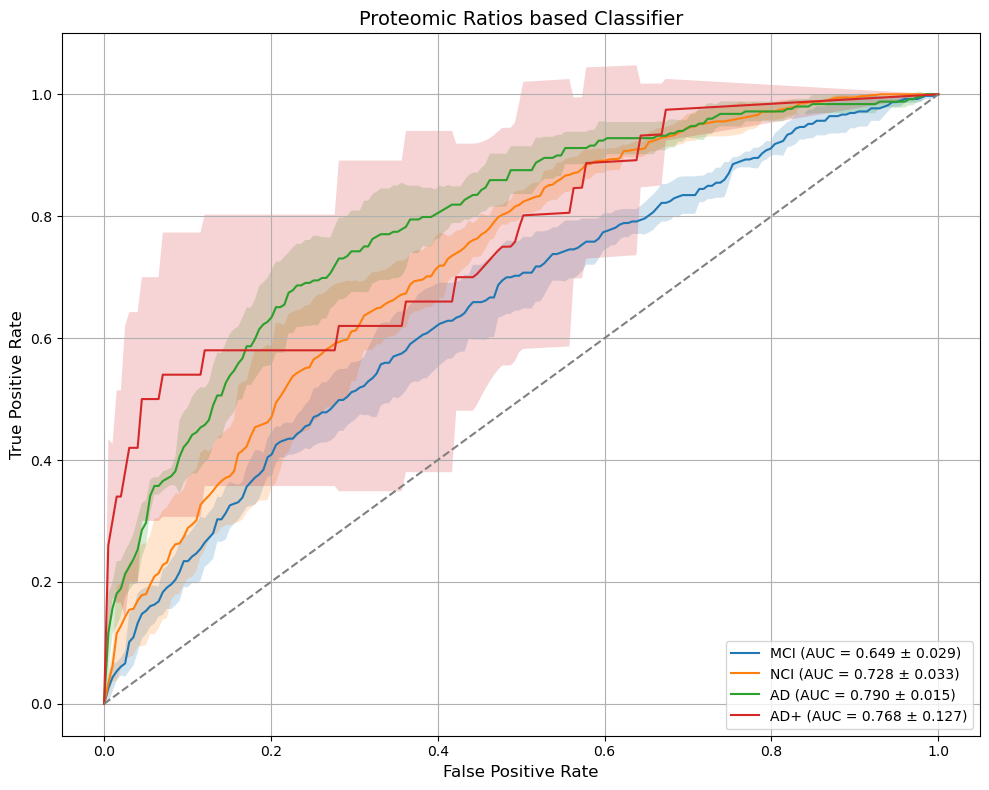

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- Config ---
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

# --- ROC Plotting ---
fpr_grid = np.linspace(0.0, 1.0, 200)
plt.figure(figsize=(10, 8))

for cls in classes:
    tprs = []
    aucs = []

    for seed in seeds:
        file_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        if not os.path.exists(file_path):
            print(f"Missing: {file_path}")
            continue

        df = pd.read_csv(file_path)
        fpr, tpr, _ = roc_curve(df["y_true"], df["y_score"])
        interp_tpr = np.interp(fpr_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    if not tprs:
        continue

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(fpr_grid, mean_tpr, label=f"{cls} (AUC = {mean_auc:.3f} ± {std_auc:.3f})")
    plt.fill_between(fpr_grid, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)

# --- Finalize plot ---
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Proteomic Ratios based Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()  # or plt.savefig("roc_ratio_models.png", dpi=300)

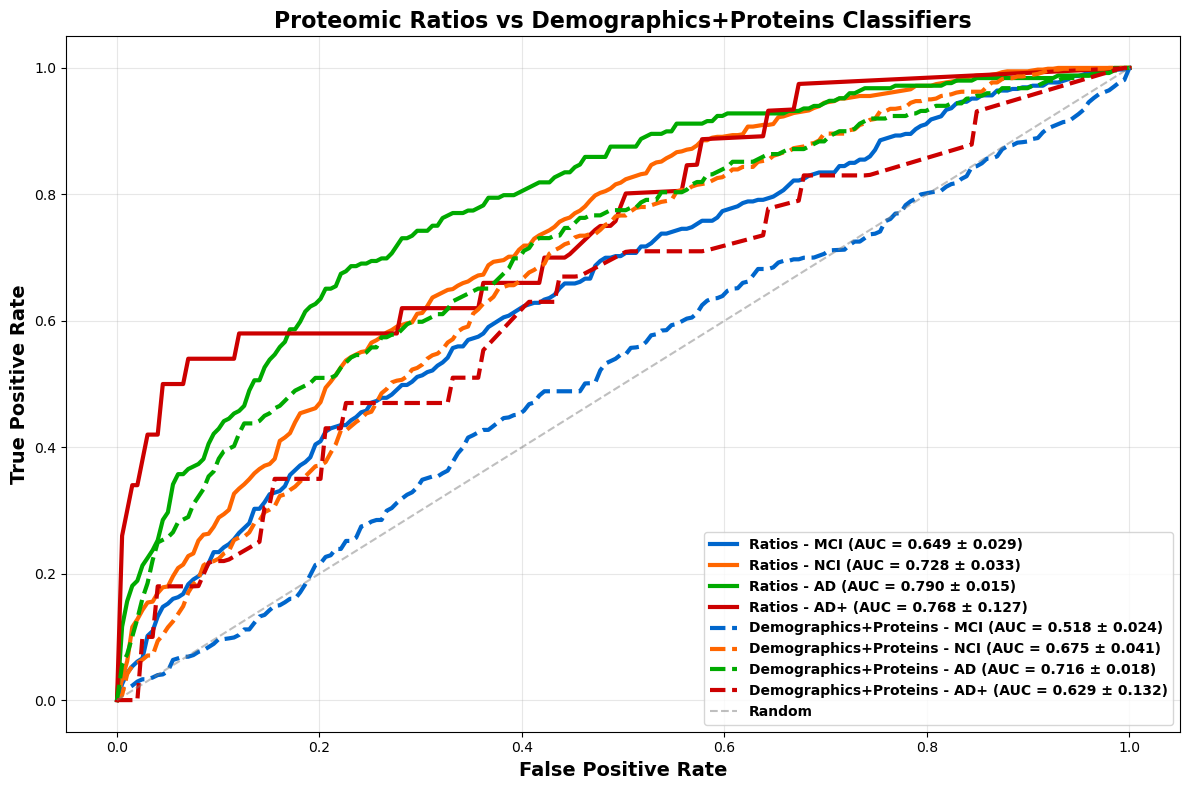

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- Config ---
ratios_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
baseline_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_fixed"
classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

# Define more contrasting colors for each class
class_colors = {
    "MCI": "#0066CC",    # bright blue
    "NCI": "#FF6600",    # bright orange
    "AD": "#00AA00",     # bright green
    "AD+": "#CC0000"     # bright red
}

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

# --- ROC Plotting ---
fpr_grid = np.linspace(0.0, 1.0, 200)
plt.figure(figsize=(12, 8))

# Plot Proteomic Ratios
for cls in classes:
    tprs = []
    aucs = []

    for seed in seeds:
        file_path = os.path.join(ratios_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path)
        fpr, tpr, _ = roc_curve(df["y_true"], df["y_score"])
        interp_tpr = np.interp(fpr_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    if not tprs:
        continue

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(fpr_grid, mean_tpr, label=f"Ratios - {cls} (AUC = {mean_auc:.3f} ± {std_auc:.3f})", 
             linewidth=3, color=class_colors[cls])

# Plot Demographics + Proteins
for cls in classes:
    tprs = []
    aucs = []

    for seed in seeds:
        file_path = os.path.join(baseline_dir, f"seed{seed}_{safe_cls(cls)}.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path)
        fpr, tpr, _ = roc_curve(df["y_true"], df["y_score"])
        interp_tpr = np.interp(fpr_grid, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    if not tprs:
        continue

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(fpr_grid, mean_tpr, label=f"Demographics+Proteins - {cls} (AUC = {mean_auc:.3f} ± {std_auc:.3f})", 
             linewidth=3, linestyle="--", color=class_colors[cls])

# --- Finalize plot ---
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.5, label="Random")
plt.xlabel("False Positive Rate", fontsize=14, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=14, fontweight='bold')
plt.title("Proteomic Ratios vs Demographics+Proteins Classifiers", fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=9, prop={'weight': 'bold'})
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# --- Config ---
ratios_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
baseline_dirs = [
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_demo_only",
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_random",
    # This is the raw proteomics plus demopgrahics model
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_fixed"
]

classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

def calculate_aucs(results_dir, classes, seeds):
    """Calculate mean AUC for each class across seeds."""
    class_aucs = {}
    
    for cls in classes:
        aucs = []
        for seed in seeds:
            file_path = os.path.join(results_dir, f"seed{seed}_{safe_cls(cls)}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if len(df) > 0 and df["y_true"].nunique() > 1:  # Check if valid for AUC
                    auc_val = roc_auc_score(df["y_true"], df["y_score"])
                    aucs.append(auc_val)
        
        if aucs:
            class_aucs[cls] = np.mean(aucs)
        else:
            class_aucs[cls] = np.nan
    
    return class_aucs

# Calculate AUCs for ratios model
ratios_aucs = calculate_aucs(ratios_dir, classes, seeds)
print("Ratios Model AUCs:")
for cls, auc_val in ratios_aucs.items():
    print(f"  {cls}: {auc_val:.4f}")

# Calculate improvements for each baseline
all_improvements = []

for baseline_dir in baseline_dirs:
    baseline_name = os.path.basename(baseline_dir)
    baseline_aucs = calculate_aucs(baseline_dir, classes, seeds)
    
    print(f"\n{baseline_name} AUCs:")
    improvements = {}
    
    for cls in classes:
        baseline_auc = baseline_aucs[cls]
        ratios_auc = ratios_aucs[cls]
        improvement = ratios_auc - baseline_auc
        improvements[cls] = improvement
        
        print(f"  {cls}: {baseline_auc:.4f} → Improvement: {improvement:+.4f}")
    
    all_improvements.append(improvements)

# Calculate average improvement across all baselines
print("\n" + "="*60)
print("AVERAGE IMPROVEMENT (Ratios vs All Baselines):")
print("="*60)

avg_improvements = {}
for cls in classes:
    cls_improvements = [imp[cls] for imp in all_improvements if not np.isnan(imp[cls])]
    if cls_improvements:
        avg_improvements[cls] = np.mean(cls_improvements)
        print(f"{cls}: {avg_improvements[cls]:+.4f}")

# Overall average across all classes and baselines
all_improvement_values = []
for imp_dict in all_improvements:
    for cls, val in imp_dict.items():
        if not np.isnan(val):
            all_improvement_values.append(val)

if all_improvement_values:
    overall_avg = np.mean(all_improvement_values)
    print(f"\nOverall Average Improvement: {overall_avg:+.4f}")

Ratios Model AUCs:
  MCI: 0.6495
  NCI: 0.7277
  AD: 0.7899
  AD+: 0.7684

proteomics_LGBM(ANML+Meta)_BASELINE_demo_only AUCs:
  MCI: 0.5508 → Improvement: +0.0987
  NCI: 0.6447 → Improvement: +0.0829
  AD: 0.6137 → Improvement: +0.1762
  AD+: 0.6218 → Improvement: +0.1466

proteomics_LGBM(ANML+Meta)_BASELINE_random AUCs:
  MCI: 0.5195 → Improvement: +0.1300
  NCI: 0.4890 → Improvement: +0.2387
  AD: 0.4896 → Improvement: +0.3003
  AD+: 0.5387 → Improvement: +0.2297

proteomics_LGBM(ANML+Meta)_fixed AUCs:
  MCI: 0.5176 → Improvement: +0.1319
  NCI: 0.6749 → Improvement: +0.0528
  AD: 0.7161 → Improvement: +0.0738
  AD+: 0.6288 → Improvement: +0.1396

AVERAGE IMPROVEMENT (Ratios vs All Baselines):
MCI: +0.1202
NCI: +0.1248
AD: +0.1834
AD+: +0.1720

Overall Average Improvement: +0.1501


Ratios Model AUCs:
  MCI: 0.6495
  NCI: 0.7277
  AD: 0.7899
  AD+: 0.7684

proteomics_LGBM(ANML+Meta)_BASELINE_demo_only AUCs:
  MCI: 0.5508 → Improvement: +0.0987
  NCI: 0.6447 → Improvement: +0.0829
  AD: 0.6137 → Improvement: +0.1762
  AD+: 0.6218 → Improvement: +0.1466

proteomics_LGBM(ANML+Meta)_BASELINE_random AUCs:
  MCI: 0.5195 → Improvement: +0.1300
  NCI: 0.4890 → Improvement: +0.2387
  AD: 0.4896 → Improvement: +0.3003
  AD+: 0.5387 → Improvement: +0.2297

proteomics_LGBM(ANML+Meta)_fixed AUCs:
  MCI: 0.5176 → Improvement: +0.1319
  NCI: 0.6749 → Improvement: +0.0528
  AD: 0.7161 → Improvement: +0.0738
  AD+: 0.6288 → Improvement: +0.1396

============================================================
AVERAGE IMPROVEMENT (Ratios vs All Baselines):
============================================================
MCI: +0.1202
NCI: +0.1248
AD: +0.1834
AD+: +0.1720

Overall Average Improvement: +0.1501

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# --- Config ---
ratios_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
baseline_dirs = [
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_demo_only",
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_random",
    # This is the raw proteomics plus demopgrahics model
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_fixed"
]

classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

def calculate_aucs(results_dir, classes, seeds):
    """Calculate mean AUC for each class across seeds."""
    class_aucs = {}
    
    for cls in classes:
        aucs = []
        for seed in seeds:
            file_path = os.path.join(results_dir, f"seed{seed}_{safe_cls(cls)}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if len(df) > 0 and df["y_true"].nunique() > 1:  # Check if valid for AUC
                    auc_val = roc_auc_score(df["y_true"], df["y_score"])
                    aucs.append(auc_val)
        
        if aucs:
            class_aucs[cls] = np.mean(aucs)
        else:
            class_aucs[cls] = np.nan
    
    return class_aucs

# Calculate AUCs for ratios model
ratios_aucs = calculate_aucs(ratios_dir, classes, seeds)

# Calculate average improvement for each baseline
print("="*60)
print("AVERAGE IMPROVEMENT (Ratios vs Each Baseline):")
print("="*60)

baseline_names = [
    "BASELINE_demo_only",
    "BASELINE_random", 
    "BASELINE_fixed"
]

for baseline_dir, baseline_name in zip(baseline_dirs, baseline_names):
    baseline_aucs = calculate_aucs(baseline_dir, classes, seeds)
    
    # Calculate improvements for each class
    improvements = []
    for cls in classes:
        baseline_auc = baseline_aucs[cls]
        ratios_auc = ratios_aucs[cls]
        if not np.isnan(baseline_auc) and not np.isnan(ratios_auc):
            improvement = ratios_auc - baseline_auc
            improvements.append(improvement)
    
    # Average across all 4 classes
    avg_improvement = np.mean(improvements) if improvements else np.nan
    print(f"{baseline_name}: {avg_improvement:+.4f}")

print("\n" + "="*60)
print("Overall Average Improvement (across all baselines):")
overall_improvements = []
for baseline_dir in baseline_dirs:
    baseline_aucs = calculate_aucs(baseline_dir, classes, seeds)
    for cls in classes:
        baseline_auc = baseline_aucs[cls]
        ratios_auc = ratios_aucs[cls]
        if not np.isnan(baseline_auc) and not np.isnan(ratios_auc):
            overall_improvements.append(ratios_auc - baseline_auc)

if overall_improvements:
    print(f"{np.mean(overall_improvements):+.4f}")

AVERAGE IMPROVEMENT (Ratios vs Each Baseline):
BASELINE_demo_only: +0.1261
BASELINE_random: +0.2247
BASELINE_fixed: +0.0995

Overall Average Improvement (across all baselines):
+0.1501


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score

# --- Config ---
ratios_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
baseline_dirs = [
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_demo_only",
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_BASELINE_random",
    # Note this is the raw proteomics plus demopgrahics model
    "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_fixed"
]

classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

def calculate_aps(results_dir, classes, seeds):
    """Calculate mean Average Precision (AP) for each class across seeds."""
    class_aps = {}
    
    for cls in classes:
        aps = []
        for seed in seeds:
            file_path = os.path.join(results_dir, f"seed{seed}_{safe_cls(cls)}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if len(df) > 0 and df["y_true"].nunique() > 1:  # Check if valid for AP
                    ap_val = average_precision_score(df["y_true"], df["y_score"])
                    aps.append(ap_val)
        
        if aps:
            class_aps[cls] = np.mean(aps)
        else:
            class_aps[cls] = np.nan
    
    return class_aps

# Calculate APs for ratios model
ratios_aps = calculate_aps(ratios_dir, classes, seeds)
print("Ratios Model Average Precision:")
for cls, ap_val in ratios_aps.items():
    print(f"  {cls}: {ap_val:.4f}")

# Calculate improvements for each baseline
all_improvements = []

for baseline_dir in baseline_dirs:
    baseline_name = os.path.basename(baseline_dir)
    baseline_aps = calculate_aps(baseline_dir, classes, seeds)
    
    print(f"\n{baseline_name} Average Precision:")
    improvements = {}
    
    for cls in classes:
        baseline_ap = baseline_aps[cls]
        ratios_ap = ratios_aps[cls]
        improvement = ratios_ap - baseline_ap
        improvements[cls] = improvement
        
        print(f"  {cls}: {baseline_ap:.4f} → Improvement: {improvement:+.4f}")
    
    all_improvements.append(improvements)

# Calculate average improvement across all baselines
print("\n" + "="*60)
print("AVERAGE IMPROVEMENT (Ratios vs All Baselines):")
print("="*60)

avg_improvements = {}
for cls in classes:
    cls_improvements = [imp[cls] for imp in all_improvements if not np.isnan(imp[cls])]
    if cls_improvements:
        avg_improvements[cls] = np.mean(cls_improvements)
        print(f"{cls}: {avg_improvements[cls]:+.4f}")

# Overall average across all classes and baselines
all_improvement_values = []
for imp_dict in all_improvements:
    for cls, val in imp_dict.items():
        if not np.isnan(val):
            all_improvement_values.append(val)

if all_improvement_values:
    overall_avg = np.mean(all_improvement_values)
    print(f"\nOverall Average Improvement: {overall_avg:+.4f}")

# Calculate average improvement for each baseline (averaged across 4 classes)
print("\n" + "="*60)
print("AVERAGE IMPROVEMENT PER BASELINE (across all 4 classes):")
print("="*60)

baseline_names = [
    "BASELINE_demo_only",
    "BASELINE_random", 
    "BASELINE_fixed"
]

for baseline_dir, baseline_name in zip(baseline_dirs, baseline_names):
    baseline_aps = calculate_aps(baseline_dir, classes, seeds)
    
    # Calculate improvements for each class
    improvements = []
    for cls in classes:
        baseline_ap = baseline_aps[cls]
        ratios_ap = ratios_aps[cls]
        if not np.isnan(baseline_ap) and not np.isnan(ratios_ap):
            improvement = ratios_ap - baseline_ap
            improvements.append(improvement)
    
    # Average across all 4 classes
    avg_improvement = np.mean(improvements) if improvements else np.nan
    print(f"{baseline_name}: {avg_improvement:+.4f}")

Ratios Model Average Precision:
  MCI: 0.4180
  NCI: 0.7268
  AD: 0.4998
  AD+: 0.3351

proteomics_LGBM(ANML+Meta)_BASELINE_demo_only Average Precision:
  MCI: 0.3349 → Improvement: +0.0831
  NCI: 0.6555 → Improvement: +0.0713
  AD: 0.2592 → Improvement: +0.2406
  AD+: 0.0332 → Improvement: +0.3019

proteomics_LGBM(ANML+Meta)_BASELINE_random Average Precision:
  MCI: 0.3067 → Improvement: +0.1113
  NCI: 0.5310 → Improvement: +0.1959
  AD: 0.1856 → Improvement: +0.3142
  AD+: 0.0652 → Improvement: +0.2700

proteomics_LGBM(ANML+Meta)_fixed Average Precision:
  MCI: 0.3011 → Improvement: +0.1169
  NCI: 0.6670 → Improvement: +0.0598
  AD: 0.4102 → Improvement: +0.0897
  AD+: 0.0531 → Improvement: +0.2820

AVERAGE IMPROVEMENT (Ratios vs All Baselines):
MCI: +0.1038
NCI: +0.1090
AD: +0.2148
AD+: +0.2846

Overall Average Improvement: +0.1780

AVERAGE IMPROVEMENT PER BASELINE (across all 4 classes):
BASELINE_demo_only: +0.1742
BASELINE_random: +0.2228
BASELINE_fixed: +0.1371


Ratios Model Average Precision:
  MCI: 0.4180
  NCI: 0.7268
  AD: 0.4998
  AD+: 0.3351

proteomics_LGBM(ANML+Meta)_BASELINE_demo_only Average Precision:
  MCI: 0.3349 → Improvement: +0.0831
  NCI: 0.6555 → Improvement: +0.0713
  AD: 0.2592 → Improvement: +0.2406
  AD+: 0.0332 → Improvement: +0.3019

proteomics_LGBM(ANML+Meta)_BASELINE_random Average Precision:
  MCI: 0.3067 → Improvement: +0.1113
  NCI: 0.5310 → Improvement: +0.1959
  AD: 0.1856 → Improvement: +0.3142
  AD+: 0.0652 → Improvement: +0.2700

proteomics_LGBM(ANML+Meta)_fixed Average Precision:
  MCI: 0.3011 → Improvement: +0.1169
  NCI: 0.6670 → Improvement: +0.0598
  AD: 0.4102 → Improvement: +0.0897
  AD+: 0.0531 → Improvement: +0.2820

============================================================
AVERAGE IMPROVEMENT (Ratios vs All Baselines):
============================================================
MCI: +0.1038
NCI: +0.1090
AD: +0.2148
AD+: +0.2846

Overall Average Improvement: +0.1780

============================================================
AVERAGE IMPROVEMENT PER BASELINE (across all 4 classes):
============================================================
BASELINE_demo_only: +0.1742
BASELINE_random: +0.2228
BASELINE_fixed: +0.1371

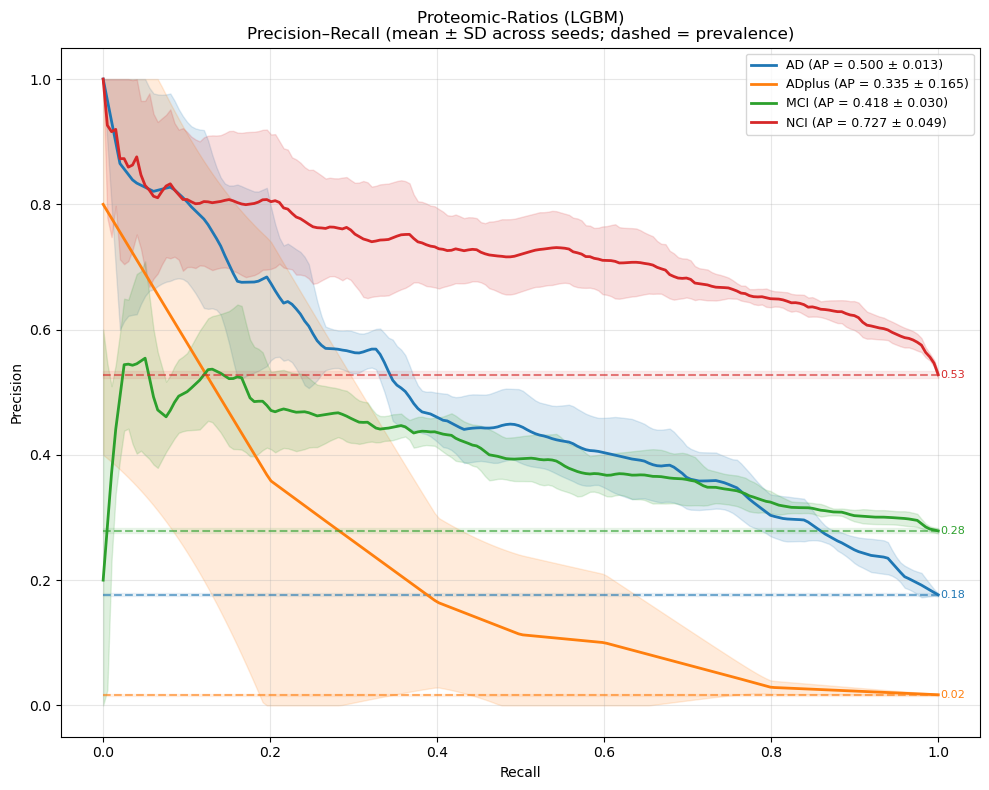

In [ ]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ====== CONFIG ======
folder = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"

def class_from_path(p):
    base = os.path.basename(p)
    return "_".join(base.split("_")[1:]).rsplit(".csv", 1)[0]

files = glob.glob(os.path.join(folder, "seed*_*.csv"))
class_names = sorted(set(class_from_path(p) for p in files))

recall_grid = np.linspace(0.0, 1.0, 200)

plt.figure(figsize=(10, 8))

for cls in class_names:
    cls_files = sorted(glob.glob(os.path.join(folder, f"seed*_{cls}.csv")))
    if not cls_files:
        print(f"[warn] No CSVs found for class={cls}")
        continue

    prec_interp_list, aps = [], []
    prevalences = []  # for PR baseline

    for path in cls_files:
        df = pd.read_csv(path)
        y_true  = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # --- PR curve ---
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        # Deduplicate recall for interpolation
        uniq_idx = np.unique(recall, return_index=True)[1]
        r_u, p_u = recall[uniq_idx], precision[uniq_idx]

        # Interpolate precision onto a common recall grid
        p_i = np.interp(recall_grid, r_u, p_u, left=p_u[0], right=p_u[-1])
        prec_interp_list.append(p_i)

        # Average Precision and prevalence (positive rate) for baseline
        aps.append(average_precision_score(y_true, y_score))
        prevalences.append(y_true.mean())

    if not prec_interp_list:
        continue

    mean_prec = np.mean(prec_interp_list, axis=0)
    std_prec  = np.std(prec_interp_list, axis=0)
    mean_ap   = float(np.mean(aps))
    std_ap    = float(np.std(aps))

    # Plot PR curve (mean ± SD)
    line, = plt.plot(recall_grid, mean_prec, lw=2,
                     label=f"{cls.replace('_',' ')} (AP = {mean_ap:.3f} ± {std_ap:.3f})")
    plt.fill_between(recall_grid,
                     np.clip(mean_prec - std_prec, 0, 1),
                     np.clip(mean_prec + std_prec, 0, 1),
                     alpha=0.15, color=line.get_color())

    # --- Add class-specific PR baseline (chance level = prevalence) ---
    prev_mean = float(np.mean(prevalences))
    prev_sd   = float(np.std(prevalences))
    # dashed baseline
    plt.hlines(prev_mean, 0, 1, colors=line.get_color(), linestyles="--", alpha=0.6)
    # light band for ±1 SD
    low = max(0.0, prev_mean - prev_sd)
    high = min(1.0, prev_mean + prev_sd)
    plt.fill_between([0, 1], [low, low], [high, high],
                     color=line.get_color(), alpha=0.08)

    # Add a tiny annotation so readers know the baseline value
    plt.text(1.002, prev_mean, f"{prev_mean:.2f}",
             color=line.get_color(), va="center", fontsize=8)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Proteomic-Ratios (LGBM)\nPrecision–Recall (mean ± SD across seeds; dashed = prevalence)")
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

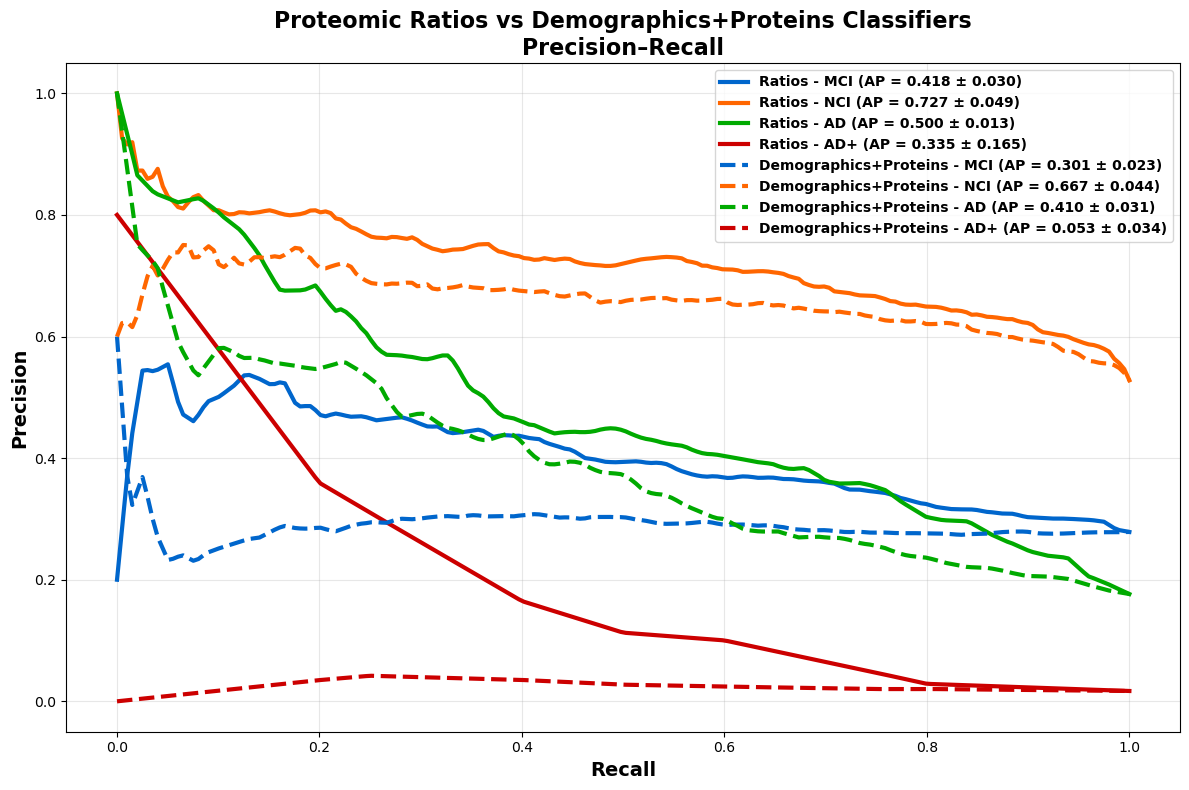

In [11]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ====== CONFIG ======
ratios_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
baseline_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_fixed"
classes = ["MCI", "NCI", "AD", "AD+"]

# Define more contrasting colors for each class
class_colors = {
    "MCI": "#0066CC",    # bright blue
    "NCI": "#FF6600",    # bright orange
    "AD": "#00AA00",     # bright green
    "AD+": "#CC0000"     # bright red
}

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

recall_grid = np.linspace(0.0, 1.0, 200)

plt.figure(figsize=(12, 8))

# Plot Proteomic Ratios
for cls in classes:
    prec_interp_list, aps = [], []
    cls_name = safe_cls(cls)
    
    for seed in [1, 2, 3, 4, 5]:
        path = os.path.join(ratios_dir, f"seed{seed}_{cls_name}.csv")
        if not os.path.exists(path):
            continue
            
        df = pd.read_csv(path)
        y_true = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # PR curve
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        # Deduplicate recall for interpolation
        uniq_idx = np.unique(recall, return_index=True)[1]
        r_u, p_u = recall[uniq_idx], precision[uniq_idx]

        # Interpolate precision onto a common recall grid
        p_i = np.interp(recall_grid, r_u, p_u, left=p_u[0], right=p_u[-1])
        prec_interp_list.append(p_i)
        aps.append(average_precision_score(y_true, y_score))

    if not prec_interp_list:
        continue

    mean_prec = np.mean(prec_interp_list, axis=0)
    mean_ap = float(np.mean(aps))
    std_ap = float(np.std(aps))

    # Plot PR curve
    plt.plot(recall_grid, mean_prec, lw=3, color=class_colors[cls],
             label=f"Ratios - {cls} (AP = {mean_ap:.3f} ± {std_ap:.3f})")

# Plot Demographics + Proteins
for cls in classes:
    prec_interp_list, aps = [], []
    cls_name = safe_cls(cls)
    
    for seed in [1, 2, 3, 4, 5]:
        path = os.path.join(baseline_dir, f"seed{seed}_{cls_name}.csv")
        if not os.path.exists(path):
            continue
            
        df = pd.read_csv(path)
        y_true = df["y_true"].astype(int).values
        y_score = df["y_score"].astype(float).values

        # PR curve
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        # Deduplicate recall for interpolation
        uniq_idx = np.unique(recall, return_index=True)[1]
        r_u, p_u = recall[uniq_idx], precision[uniq_idx]

        # Interpolate precision onto a common recall grid
        p_i = np.interp(recall_grid, r_u, p_u, left=p_u[0], right=p_u[-1])
        prec_interp_list.append(p_i)
        aps.append(average_precision_score(y_true, y_score))

    if not prec_interp_list:
        continue

    mean_prec = np.mean(prec_interp_list, axis=0)
    mean_ap = float(np.mean(aps))
    std_ap = float(np.std(aps))

    # Plot PR curve (dashed)
    plt.plot(recall_grid, mean_prec, lw=3, linestyle="--", color=class_colors[cls],
             label=f"Demographics+Proteins - {cls} (AP = {mean_ap:.3f} ± {std_ap:.3f})")

plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.title("Proteomic Ratios vs Demographics+Proteins Classifiers\nPrecision–Recall", fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=9, prop={'weight': 'bold'})
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.calibration import calibration_curve

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        mask = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if mask.sum() > 0:
            acc = y_true[mask].mean()
            conf = y_prob[mask].mean()
            ece += (mask.sum()/len(y_prob)) * abs(acc - conf)
    return ece

for cls in classes:
    plt.figure(figsize=(6,6))
    for seed in seeds:
        path = os.path.join(out_dir, f"seed{seed}_{cls}.csv")
        df   = pd.read_csv(path)
        y_true, y_score = df["y_true"].values, df["y_score"].values

        prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=10, strategy="uniform")
        plt.plot(prob_pred, prob_true, marker="o", label=f"Seed {seed}, ECE={expected_calibration_error(y_true, y_score):.3f}")

    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("Predicted probability"); plt.ylabel("True frequency")
    plt.title(f"Calibration curve ({cls})")
    plt.legend()
    plt.show()

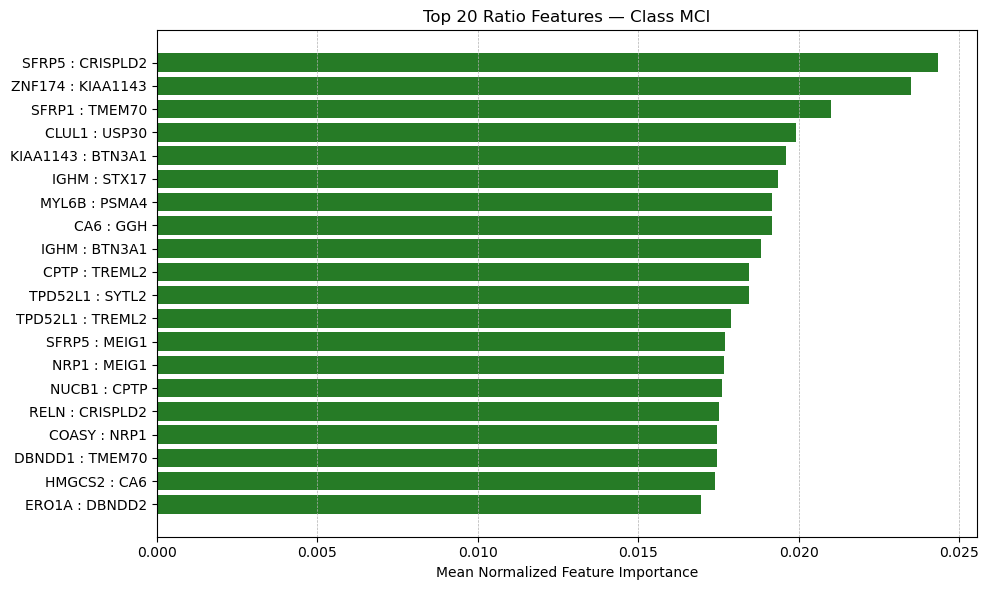

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_MCI.png


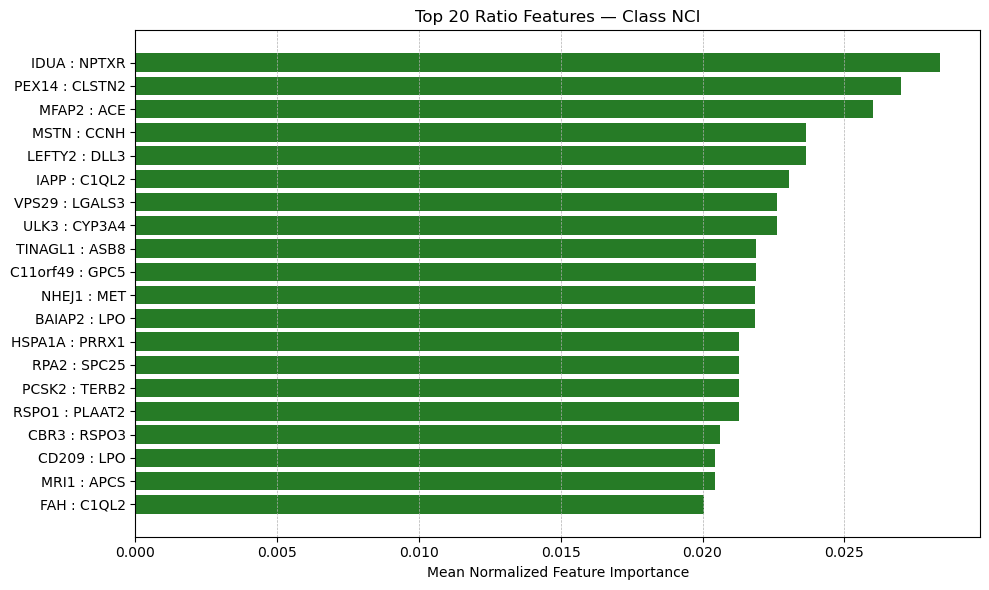

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_NCI.png


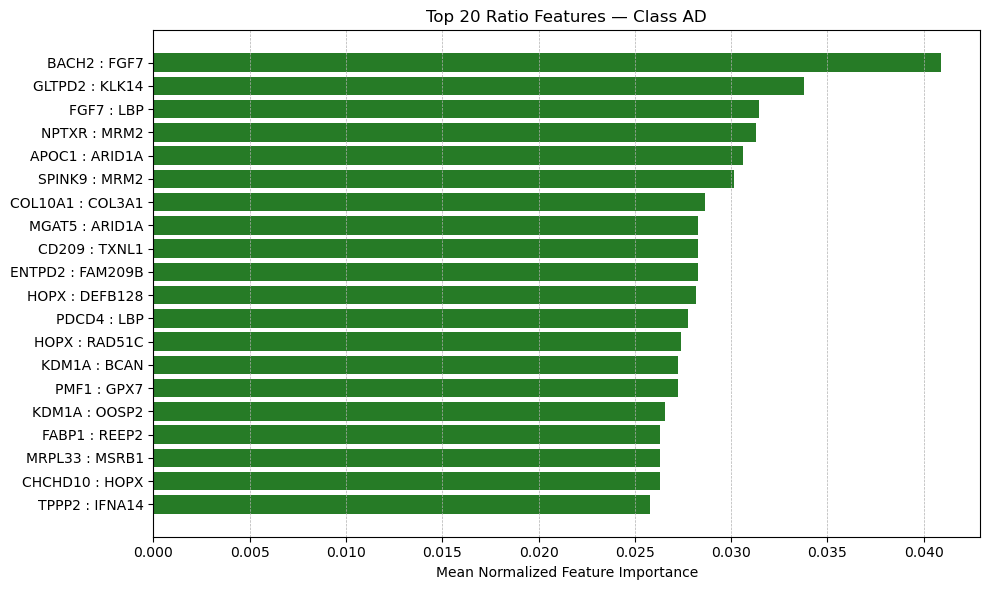

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_AD.png


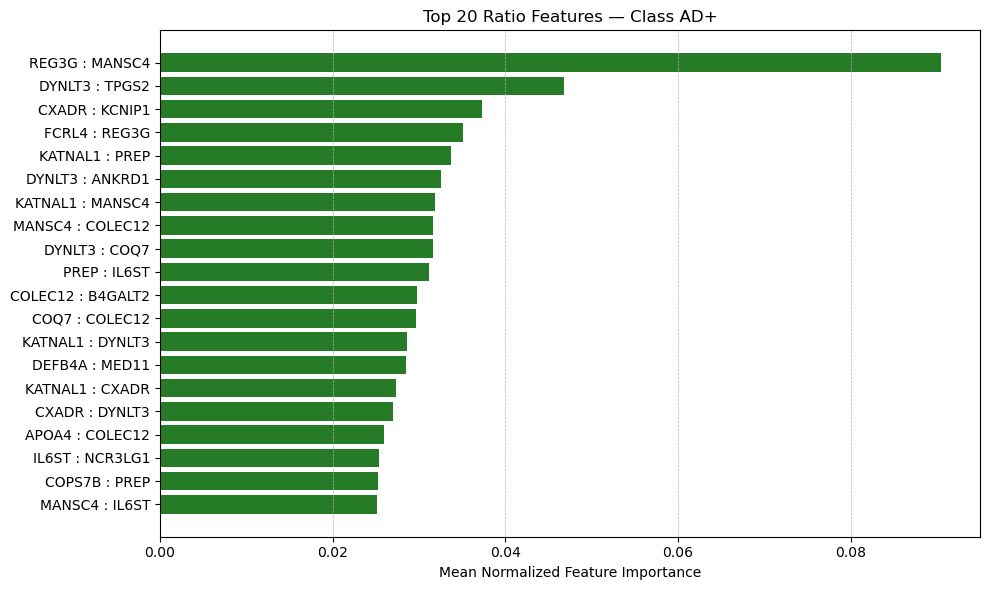

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_ADplus.png


In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
protein_metadata_path = "/Users/adithyamadduri/Downloads/syn65414912/OhNM2025_ROSMAP_plasma_Soma7k_protein_metadata.csv"

classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]
top_n = 20  # number of top features to display

# ---- Load SeqId → GeneSymbol mapping ----
df_meta = pd.read_csv(protein_metadata_path)
seqid_to_gene = dict(zip(df_meta["SeqId"], df_meta["EntrezGeneSymbol"]))

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

# ---- Helper: map ratio feature name to gene symbols ----
def map_ratio_name(name):
    if "_minus_" in name:
        left, right = name.split("_minus_")
        gene_left = seqid_to_gene.get(left, left)
        gene_right = seqid_to_gene.get(right, right)
        return f"{gene_left} : {gene_right}"
    elif "_div_" in name:  # Support old naming convention for backwards compatibility
        left, right = name.split("_div_")
        gene_left = seqid_to_gene.get(left, left)
        gene_right = seqid_to_gene.get(right, right)
        return f"{gene_left} : {gene_right}"
    return seqid_to_gene.get(name, name)

# === MAIN LOOP ===
for cls in classes:
    feature_importance_list = []

    for seed in seeds:
        pkl_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl")
        if not os.path.exists(pkl_path):
            print(f"Missing: {pkl_path}")
            continue

        with open(pkl_path, "rb") as f:
            automl = pickle.load(f)

        model = automl.model.estimator
        importances = model.feature_importances_
        features = automl.feature_names_in_

        # Normalize importance
        norm_importance = importances / importances.sum()
        feature_importance_list.append(pd.Series(norm_importance, index=features))

    if not feature_importance_list:
        print(f"No data for class: {cls}")
        continue

    # Combine across seeds
    df_importances = pd.concat(feature_importance_list, axis=1)
    df_importances.columns = [f"seed{i}" for i in range(len(df_importances.columns))]

    # Compute mean across seeds
    df_importances["mean"] = df_importances.mean(axis=1)

    # Take top N
    df_top = df_importances.sort_values("mean", ascending=False).head(top_n)

    # Map feature names
    df_top["mapped_name"] = df_top.index.map(map_ratio_name)

    # === Plot ===
    plt.figure(figsize=(10, max(6, 0.3 * top_n)))
    plt.barh(y=df_top["mapped_name"][::-1], width=df_top["mean"][::-1], color="darkgreen", alpha=0.85)

    plt.xlabel("Mean Normalized Feature Importance")
    plt.title(f"Top {top_n} Ratio Features — Class {cls}")
    plt.tight_layout()
    plt.grid(True, axis="x", linestyle="--", linewidth=0.5)

    # Save plot
    plot_path = os.path.join(out_dir, f"top{top_n}_ratios_{safe_cls(cls)}.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"Saved: {plot_path}")

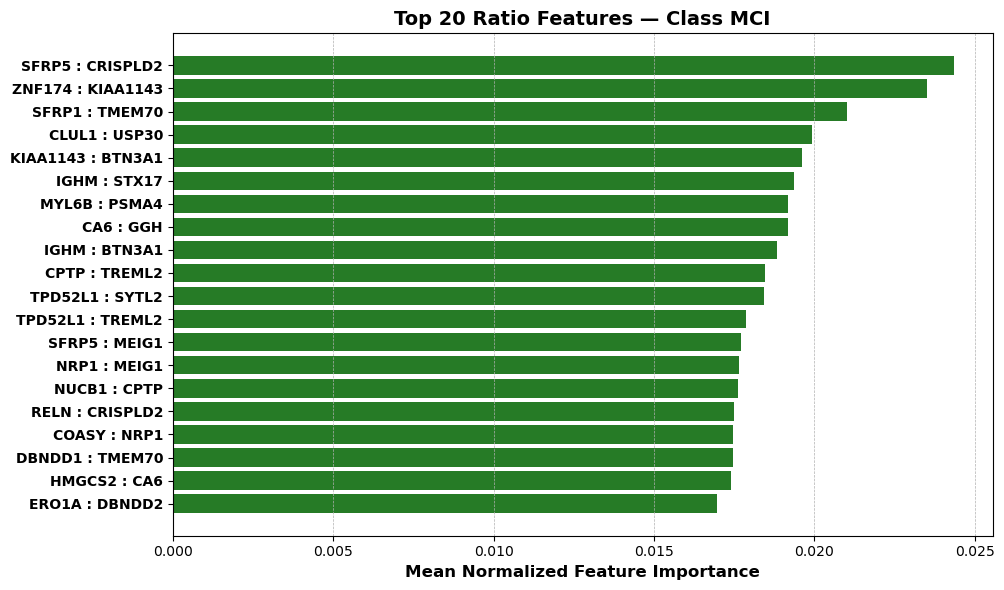

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_MCI.png


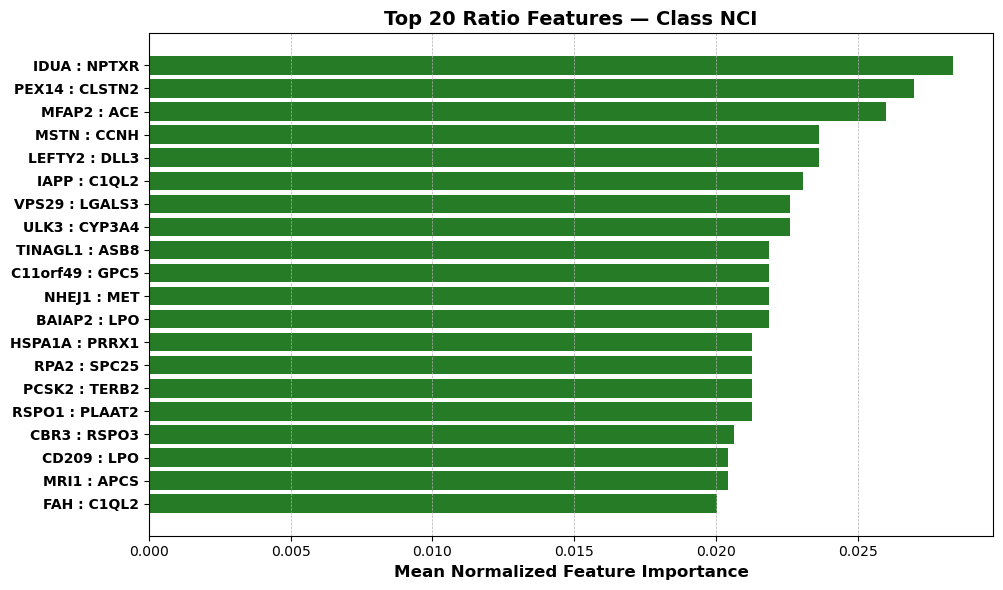

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_NCI.png


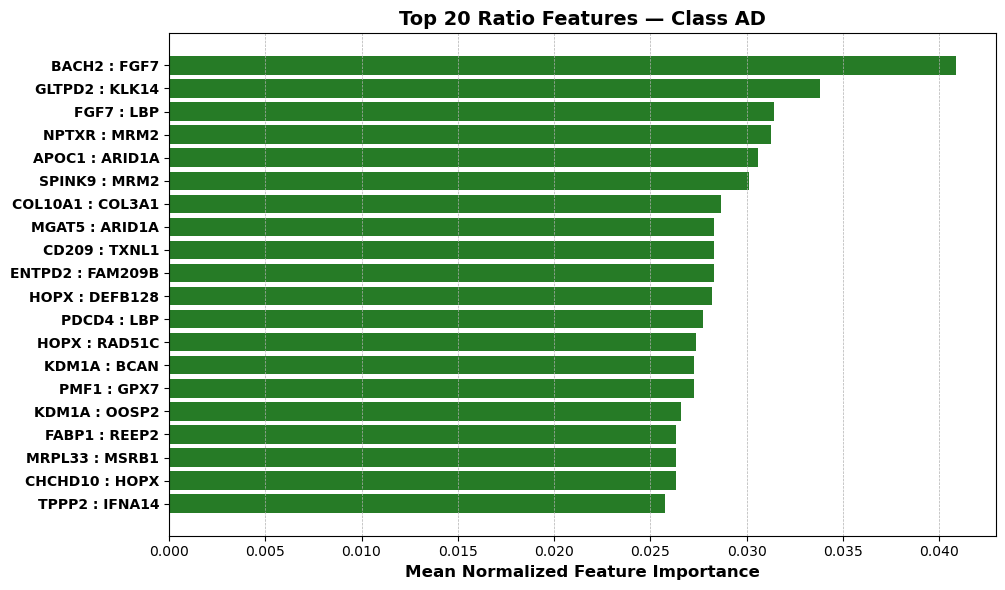

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_AD.png


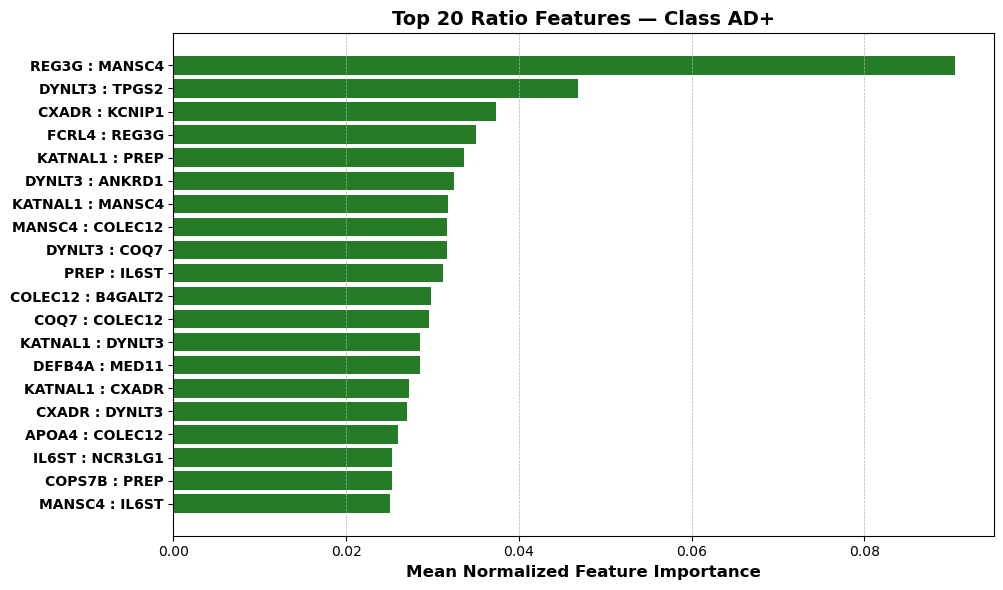

Saved: /Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe/top20_ratios_ADplus.png


In [10]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
out_dir = "/Users/adithyamadduri/Desktop/Projects/proteomics_LGBM(ANML+Meta)_RATIOS_fixed_rfe"
protein_metadata_path = "/Users/adithyamadduri/Downloads/syn65414912/OhNM2025_ROSMAP_plasma_Soma7k_protein_metadata.csv"

classes = ["MCI", "NCI", "AD", "AD+"]
seeds = [1, 2, 3, 4, 5]
top_n = 20  # number of top features to display

# ---- Load SeqId → GeneSymbol mapping ----
df_meta = pd.read_csv(protein_metadata_path)
seqid_to_gene = dict(zip(df_meta["SeqId"], df_meta["EntrezGeneSymbol"]))

def safe_cls(c):
    return c.replace("+", "plus").replace(" ", "_").replace("/", "-")

# ---- Helper: map ratio feature name to gene symbols ----
def map_ratio_name(name):
    if "_minus_" in name:
        left, right = name.split("_minus_")
        gene_left = seqid_to_gene.get(left, left)
        gene_right = seqid_to_gene.get(right, right)
        return f"{gene_left} : {gene_right}"
    elif "_div_" in name:  # Support old naming convention for backwards compatibility
        left, right = name.split("_div_")
        gene_left = seqid_to_gene.get(left, left)
        gene_right = seqid_to_gene.get(right, right)
        return f"{gene_left} : {gene_right}"
    return seqid_to_gene.get(name, name)

# === MAIN LOOP ===
for cls in classes:
    feature_importance_list = []

    for seed in seeds:
        pkl_path = os.path.join(out_dir, f"seed{seed}_{safe_cls(cls)}_automl.pkl")
        if not os.path.exists(pkl_path):
            print(f"Missing: {pkl_path}")
            continue

        with open(pkl_path, "rb") as f:
            automl = pickle.load(f)

        model = automl.model.estimator
        importances = model.feature_importances_
        features = automl.feature_names_in_

        # Normalize importance
        norm_importance = importances / importances.sum()
        feature_importance_list.append(pd.Series(norm_importance, index=features))

    if not feature_importance_list:
        print(f"No data for class: {cls}")
        continue

    # Combine across seeds
    df_importances = pd.concat(feature_importance_list, axis=1)
    df_importances.columns = [f"seed{i}" for i in range(len(df_importances.columns))]

    # Compute mean across seeds
    df_importances["mean"] = df_importances.mean(axis=1)

    # Take top N
    df_top = df_importances.sort_values("mean", ascending=False).head(top_n)

    # Map feature names
    df_top["mapped_name"] = df_top.index.map(map_ratio_name)

    # === Plot ===
    plt.figure(figsize=(10, max(6, 0.3 * top_n)))
    plt.barh(y=df_top["mapped_name"][::-1], width=df_top["mean"][::-1], color="darkgreen", alpha=0.85)

    plt.xlabel("Mean Normalized Feature Importance", fontsize=12, fontweight='bold')
    plt.title(f"Top {top_n} Ratio Features — Class {cls}", fontsize=14, fontweight='bold')
    plt.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.grid(True, axis="x", linestyle="--", linewidth=0.5)
    
    # Make y-axis labels bold
    ax = plt.gca()
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    # Save plot
    plot_path = os.path.join(out_dir, f"top{top_n}_ratios_{safe_cls(cls)}.png")
    plt.savefig(plot_path, dpi=300)
    plt.show()

    print(f"Saved: {plot_path}")